In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

In [ ]:
project_id = '******'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [4]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


In [7]:
# prompt: Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records
bqdf = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
bqdf.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,51501,937,4,38.422501
1,18321,895,2,19.835
2,75625,958,1,61.0
3,31460,1073,1,54.0
4,2100,884,2,92.5
5,15212,1026,1,7.95
6,7076,850,2,38.635001
7,9429,924,1,350.0
8,49080,843,1,19.99
9,7419,869,1,59.5


In [8]:
# prompt: 1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.

df_train, df_test = train_test_split(bqdf, test_size=0.2, random_state=42)
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_train)
kmeans.to_gbq(model_name=f"{project_id}.{dataset_name}.{model_name}", replace=True)

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [9]:
# prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.

predictions_df = kmeans.predict(df_test)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
3,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.634371396579...",31460,1073,1,54.0
10,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.347828503506...",9910,892,1,49.5
23,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.373327825032...",2418,943,1,98.0
24,1,"[{'CENTROID_ID': 1, 'DISTANCE': 0.929639428477...",65233,1042,2,30.135
27,4,"[{'CENTROID_ID': 4, 'DISTANCE': 0.522972627298...",61197,910,4,58.0
30,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.808398110228...",11415,993,1,149.0
31,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.419045201096...",77628,834,3,67.326667
50,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.625502436403...",33833,829,1,39.75
56,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.835591213542...",29584,958,1,73.989998
57,3,"[{'CENTROID_ID': 3, 'DISTANCE': 1.654240080177...",2809,888,1,4.01


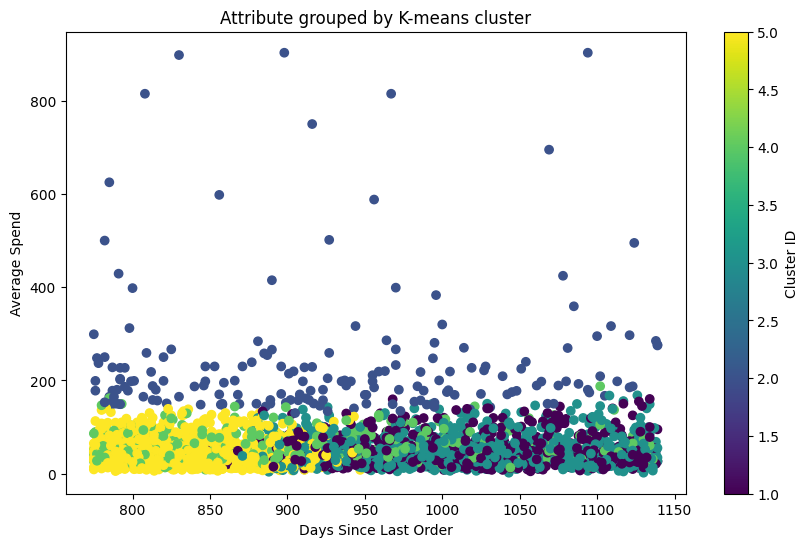

In [12]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')

# Customize the plot
plt.title('Attribute grouped by K-means cluster')
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.colorbar(label='Cluster ID')

# Display the plot
plt.show()

In [13]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,48.17,1.29,1010.96
1,cluster 2,220.75,1.25,916.40
2,cluster 3,47.36,1.26,1022.17
3,cluster 4,58.40,3.69,911.24
4,cluster 5,45.90,1.31,839.55


In [14]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $48.17, count of orders per person 1.29, days since last order 1010.96
cluster 2, average spend $220.75, count of orders per person 1.25, days since last order 916.4
cluster 3, average spend $47.36, count of orders per person 1.26, days since last order 1022.17
cluster 4, average spend $58.4, count of orders per person 3.69, days since last order 911.24
cluster 5, average spend $45.9, count of orders per person 1.31, days since last order 839.55


In [15]:
model = GenerativeModel("gemini-1.0-pro")

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step. Identify the cluster number, the title of the person, a persona for them and the next marketing step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

responses = model.generate_content(
   prompt,
   generation_config={
      "temperature": 0.1,
      "max_output_tokens": 800,
      "top_p": 1.0,
      "top_k": 40,
   }
)

print(responses.text)

## Cluster Analysis and Marketing Strategies:

Based on the provided data, here's an analysis of each customer cluster and proposed marketing strategies:

**Cluster 1:**

* **Title:** The Lapsed Customer
* **Persona:** This customer made a single purchase over 1000 days ago and hasn't returned. They likely had a positive experience but haven't found a reason to come back.
* **Next Marketing Step:** 
    1. **Reactivation Campaign:** Send a personalized email or targeted ad reminding them of their previous purchase and highlighting new products or promotions that might interest them.
    2. **Offer Incentives:** Provide a discount or free shipping to encourage them to make another purchase.
    3. **Personalized Recommendations:** Leverage purchase history and browsing behavior to suggest relevant products they might be interested in.

**Cluster 2:**

* **Title:** The High-Value Buyer
* **Persona:** This customer spends a significant amount per purchase but buys infrequently (around onc